<Header> This is is where we develop a baseline factor model that allows us to take certain factors and use them in multi-OLS regression to predict our excess return signals on a security level. These signals are absolute. </Header>

In [46]:
#First, import our packages for the database connection and dataframe access
import mysql.connector
import pandas as pd
import statsmodels.api as sm
import numpy as np
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [47]:
import yfinance as yf
from datetime import datetime

start_date='2021-09-16'
# Download Bitcoin price data from Yahoo Finance (data available as far back as 2014-09-16)
btc_df = yf.download('BTC-USD', start=start_date, end=datetime.now(), interval='1d')

# Function to calculate 7-day ROI from Monday to Monday to follow tournament's Monday to Monday forecast schedule.

def calculate_monday_to_monday_roi(btc_df):
    monday_close = btc_df[btc_df.index.weekday == 0]['Close']
    next_monday_close = monday_close.shift(-1)  # Shift by 1 week
    weekly_returns = pd.DataFrame({'Monday_Close': monday_close, 'Next_Monday_Close': next_monday_close})
    weekly_returns.dropna(inplace=True)
    weekly_returns['7_Day_ROI'] = (weekly_returns['Next_Monday_Close'] - weekly_returns['Monday_Close']) / weekly_returns['Monday_Close'] * 100
    weekly_returns = weekly_returns[['7_Day_ROI']]  # Only keep the 7_Day_ROI
    return weekly_returns

# Get the weekly BTC ROI data
weekly_btc_df = calculate_monday_to_monday_roi(btc_df)


AAPL_df = yf.download('AAPL', start=start_date, end=datetime.now(), interval='1d')
weekly_AAPL_df = calculate_monday_to_monday_roi(AAPL_df)



TSLA_df = yf.download('TSLA', start=start_date, end=datetime.now(), interval='1d')
weekly_TSLA_df = calculate_monday_to_monday_roi(TSLA_df)
weekly_TSLA_df.head()


NVDA_df = yf.download('NVDA', start=start_date, end=datetime.now(), interval='1d')
weekly_NVDA_df = calculate_monday_to_monday_roi(NVDA_df)
weekly_NVDA_df.head()

AMD_df = yf.download('AMD', start=start_date, end=datetime.now(), interval='1d')
weekly_AMD_df = calculate_monday_to_monday_roi(AMD_df)
weekly_AMD_df.head()


GOOG_df = yf.download('GOOG', start=start_date, end=datetime.now(), interval='1d')
weekly_GOOG_df = calculate_monday_to_monday_roi(AMD_df)
weekly_GOOG_df.head()

weekly_AAPL_df.rename(columns={'7_Day_ROI': 'AAPL_7_Day_ROI'}, inplace=True)
weekly_TSLA_df.rename(columns={'7_Day_ROI': 'TSLA_7_Day_ROI'}, inplace=True)
weekly_AMD_df.rename(columns={'7_Day_ROI': 'AMD_7_Day_ROI'}, inplace=True)
weekly_NVDA_df.rename(columns={'7_Day_ROI': 'NVDA_7_Day_ROI'}, inplace=True)
weekly_GOOG_df.rename(columns={'7_Day_ROI': 'GOOG_7_Day_ROI'}, inplace=True)


combined_df = pd.concat([weekly_btc_df, weekly_AAPL_df, weekly_TSLA_df, weekly_NVDA_df, weekly_AMD_df, weekly_GOOG_df], axis=1)
combined_df.reset_index(inplace=True)
combined_df['PERMNO'] = 10001
combined_df.insert(0, 'PERMNO', combined_df.pop('PERMNO'))
combined_df.rename(columns={'7_Day_ROI': 'RET'}, inplace=True)
combined_df.tail()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,PERMNO,Date,RET,AAPL_7_Day_ROI,TSLA_7_Day_ROI,NVDA_7_Day_ROI,AMD_7_Day_ROI,GOOG_7_Day_ROI
144,10001,2024-06-24,4.271196,4.136639,14.941395,5.240879,-1.597502,-1.597502
145,10001,2024-07-01,-9.779935,5.107270,20.527972,3.137565,13.317268,13.317268
146,10001,2024-07-08,14.399155,2.888239,-0.118606,0.187212,0.637976,0.637976
147,10001,2024-07-15,4.185434,-4.453920,-0.447279,-3.815012,-13.323698,-13.323698
148,10001,2024-07-22,NaN,-2.554028,-7.717383,-9.672984,-10.341949,-10.341949


In [48]:
# Assuming 'combined_df' is your DataFrame and it has been defined earlier

# List of specific columns to apply NaN fixing
columns_to_fix = ['AAPL_7_Day_ROI', 'TSLA_7_Day_ROI', 'NVDA_7_Day_ROI', 'AMD_7_Day_ROI', 'GOOG_7_Day_ROI']

# Function to find the next non-NaN value in the series
def find_next_non_nan(series, start_index, direction=1):
    if direction == 1:  # Search forwards
        for i in range(start_index + 1, len(series)):
            if not pd.isnull(series[i]):
                return series[i]
    else:  # Search backwards
        for i in range(start_index - 1, -1, -1):
            if not pd.isnull(series[i]):
                return series[i]
    return np.nan  # Return np.nan if no non-NaN value is found

# Apply the NaN fixing logic
for column in columns_to_fix:
    for i in range(len(combined_df[column])):
        if pd.isnull(combined_df[column].iloc[i]):
            # Find the next non-NaN values in both directions
            prev_val = find_next_non_nan(combined_df[column], i, direction=-1)
            next_val = find_next_non_nan(combined_df[column], i, direction=1)
            
            # Calculate the average if both values are not NaN, otherwise use the non-NaN value
            if not pd.isnull(prev_val) and not pd.isnull(next_val):
                combined_df[column].iloc[i] = (prev_val + next_val) / 2
            elif not pd.isnull(prev_val):
                combined_df[column].iloc[i] = prev_val
            elif not pd.isnull(next_val):
                combined_df[column].iloc[i] = next_val
            # If both are NaN, do nothing (or handle as needed)

C:\Users\clint\AppData\Local\Temp\ipykernel_20172\128770.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  combined_df[column].iloc[i] = (prev_val + next_val) / 2
C:\Users\clint\AppData\Local\Temp\ipykernel_20172\128770.py:28: SettingWith

In [49]:
# To find entries with NaN values in the DataFrame `combined_df`
nan_entries = combined_df[combined_df.isna().any(axis=1)]
nan_entries

,PERMNO,Date,RET,AAPL_7_Day_ROI,TSLA_7_Day_ROI,NVDA_7_Day_ROI,AMD_7_Day_ROI,GOOG_7_Day_ROI
148,10001,2024-07-22,NaN,-2.554028,-7.717383,-9.672984,-10.341949,-10.341949


In [50]:
# To find entries with NaN values in the DataFrame `combined_df`
nan_entries = combined_df[combined_df.isna().any(axis=1)]
nan_entries

,PERMNO,Date,RET,AAPL_7_Day_ROI,TSLA_7_Day_ROI,NVDA_7_Day_ROI,AMD_7_Day_ROI,GOOG_7_Day_ROI
148,10001,2024-07-22,NaN,-2.554028,-7.717383,-9.672984,-10.341949,-10.341949


In [51]:
universe_df_with_external_factors_filtered=combined_df

In [52]:
#Defining the factor model that takes a dataframe of the required columns (unique identifier, date/index column, returns columns, and a set of factors)
def olsfactormodel(df_attached, lookbackwindow:int, returnsvec:bool):

    #Assign passed dataframe to new dataframe
    df = df_attached.copy(deep=True)
    
    #We generate our list of unique tickers using the column in the unique identifier position (0, or leftmost column)
    uniqueTickerList = df.iloc[:,0].unique()
    
    #Initialize large df to drop results of regression for each security at each regression date
    containerdf = pd.DataFrame()
                
    #Set our lookback window to 24 periods (months in this case). This means that we will run a regression for each period (after the first 24 months) using the previous 24 months as data
    LookBack_Window=lookbackwindow
    
    #We will now create a new set of columns for the Beta and P-value for each of our factors. We will do this by iterating through each factor and columns for the beta coefficients
    factorlist = list(df.columns[3:])
    
    #For each factor, define an empty column to hold the corresponding coefficient
    for factor in factorlist: 
        df["Beta_" + factor] = 0


    #For each factor, define an empty column to hold the corresponding t-stat/p-value
    for factor in factorlist: 
        df["P-Value_" + factor] = 0
    
    #Initialize global parameter(s) regardless of factor count
    df["R_squared"] = 0
    df["Constant B0"] = 0

    #For each identifier (ticker), generate a dataframe from the broader dataframe that 
    for ticker in uniqueTickerList:
        
        #For each unique identifier (ticker), we create a dataframe with observations from that particular identifier
        ticker_specific_universe_df = df.loc[df.iloc[:,0] == ticker]
        
        #We then sort our date/index column in position 1 to ensure our date is ascending from the earliest available
        ticker_specific_universe_df = ticker_specific_universe_df.sort_values(by= ticker_specific_universe_df.columns[1])

        #Shift our returns data back by one period. This way, we regress "t" factors to "t+1" returns, and our betas become forecasts
        ticker_specific_universe_df['RET'] = ticker_specific_universe_df['RET'].shift(-1)

        if returnsvec == True:
            ticker_specific_universe_df = ticker_specific_universe_df.tail(LookBack_Window+1)

        #For each lookback window span, train an OLS and collect the results
        for x in range(0, (len(ticker_specific_universe_df)-LookBack_Window)):
            
            # Define the independent variables (X) and dependent variable (Y). X's are defined by our factor columns and our returns are defined in our third left-most column (position 2)
            X = ticker_specific_universe_df[factorlist][x:x+LookBack_Window]
            Y = ticker_specific_universe_df[ticker_specific_universe_df.columns[2]][x:x+LookBack_Window]
    
            #Add a constant term to the independent variables, check impact
            X = sm.add_constant(X)
        
            #Fit the linear regression model
            model = sm.OLS(Y, X)
            results = model.fit()
            
            #Place our regression coefficients into their appropriate columns
            ticker_specific_universe_df.loc[ticker_specific_universe_df.index[x+LookBack_Window], "Constant B0"] = results.params[0]
            ticker_specific_universe_df.loc[ticker_specific_universe_df.index[x+LookBack_Window], "R_squared"] = results.rsquared
    
            #We do the same dynamically using our list of factors and placing into the appropriate factor column
            #Define an index (starting position for inserting regression params)
            i = 3 + len(factorlist) - 1
            
            for index in range(len(factorlist)):
                #increase our indices by one for each factor
                index+=1
                i+=1
                j = i+len(factorlist)
                
                ticker_specific_universe_df.loc[ticker_specific_universe_df.index[x+LookBack_Window], ticker_specific_universe_df.columns[i]] = results.params[index]
                ticker_specific_universe_df.loc[ticker_specific_universe_df.index[x+LookBack_Window], ticker_specific_universe_df.columns[j]] = results.pvalues[index]

        #Add ticker dataframe to larger container dataframe
        if returnsvec==True:
            containerdf = pd.concat([containerdf, ticker_specific_universe_df[ticker_specific_universe_df["date"]==np.max(ticker_specific_universe_df.date)]], ignore_index=True)
        else:
            containerdf = pd.concat([containerdf, ticker_specific_universe_df], ignore_index=True)
    return containerdf

In [53]:
returnsdf = olsfactormodel(universe_df_with_external_factors_filtered,24,False)
returnsdf.tail()

C:\Users\clint\AppData\Local\Temp\ipykernel_20172\3525071642.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ticker_specific_universe_df.loc[ticker_specific_universe_df.index[x+LookBack_Window], "Constant B0"] = results.params[0]
C:\Users\clint\AppData\Local\Temp\ipykernel_20172\3525071642.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10812924247455591' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ticker_specific_universe_df.loc[ticker_specific_universe_df.index[x+LookBack_Window], "Constant B0"] = results.params[0]
C:\Users\clint\AppData\Local\Temp\ipykernel_20172\3525071642.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise

,PERMNO,Date,RET,AAPL_7_Day_ROI,TSLA_7_Day_ROI,NVDA_7_Day_ROI,AMD_7_Day_ROI,GOOG_7_Day_ROI,Beta_AAPL_7_Day_ROI,Beta_TSLA_7_Day_ROI,Beta_NVDA_7_Day_ROI,Beta_AMD_7_Day_ROI,Beta_GOOG_7_Day_ROI,P-Value_AAPL_7_Day_ROI,P-Value_TSLA_7_Day_ROI,P-Value_NVDA_7_Day_ROI,P-Value_AMD_7_Day_ROI,P-Value_GOOG_7_Day_ROI,R_squared,Constant B0
144,10001,2024-06-24,-9.779935,4.136639,14.941395,5.240879,-1.597502,-1.597502,-0.920044,-0.010879,0.166745,0.101363,0.101363,0.087977,0.954644,0.542914,0.458082,0.458082,0.190902,1.298581
145,10001,2024-07-01,14.399155,5.107270,20.527972,3.137565,13.317268,13.317268,-0.682838,-0.192182,0.235378,0.204336,0.204336,0.199494,0.326062,0.373171,0.158303,0.158303,0.291285,0.816066
146,10001,2024-07-08,4.185434,2.888239,-0.118606,0.187212,0.637976,0.637976,-0.558316,-0.108791,0.130754,0.278146,0.278146,0.326375,0.621140,0.629685,0.078127,0.078127,0.245895,1.541288
147,10001,2024-07-15,NaN,-4.453920,-0.447279,-3.815012,-13.323698,-13.323698,-0.485635,-0.185354,0.127536,0.326505,0.326505,0.372363,0.406398,0.625817,0.042544,0.042544,0.282783,2.077368
148,10001,2024-07-22,NaN,-2.554028,-7.717383,-9.672984,-10.341949,-10.341949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


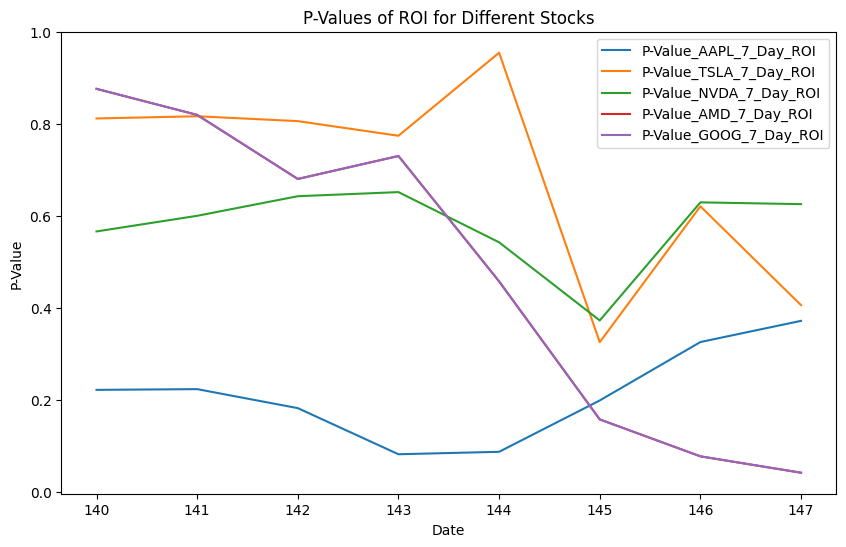

In [54]:
import matplotlib.pyplot as plt
returnsdf_cut = returnsdf.iloc[140:]
# Extract the columns from the dataframe
p_values = returnsdf_cut[['P-Value_AAPL_7_Day_ROI', 'P-Value_TSLA_7_Day_ROI', 'P-Value_NVDA_7_Day_ROI', 'P-Value_AMD_7_Day_ROI', 'P-Value_GOOG_7_Day_ROI']]

# Plot the columns
p_values.plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('P-Value')
plt.title('P-Values of ROI for Different Stocks')
plt.legend(loc='upper right')
plt.show()

In [55]:
returnsdf['beta_sum'] = returnsdf.filter(like='Beta').sum(axis=1)
returnsdf.tail()

,PERMNO,Date,RET,AAPL_7_Day_ROI,TSLA_7_Day_ROI,NVDA_7_Day_ROI,AMD_7_Day_ROI,GOOG_7_Day_ROI,Beta_AAPL_7_Day_ROI,Beta_TSLA_7_Day_ROI,...,Beta_AMD_7_Day_ROI,Beta_GOOG_7_Day_ROI,P-Value_AAPL_7_Day_ROI,P-Value_TSLA_7_Day_ROI,P-Value_NVDA_7_Day_ROI,P-Value_AMD_7_Day_ROI,P-Value_GOOG_7_Day_ROI,R_squared,Constant B0,beta_sum
144,10001,2024-06-24,-9.779935,4.136639,14.941395,5.240879,-1.597502,-1.597502,-0.920044,-0.010879,...,0.101363,0.101363,0.087977,0.954644,0.542914,0.458082,0.458082,0.190902,1.298581,-0.561451
145,10001,2024-07-01,14.399155,5.107270,20.527972,3.137565,13.317268,13.317268,-0.682838,-0.192182,...,0.204336,0.204336,0.199494,0.326062,0.373171,0.158303,0.158303,0.291285,0.816066,-0.230970
146,10001,2024-07-08,4.185434,2.888239,-0.118606,0.187212,0.637976,0.637976,-0.558316,-0.108791,...,0.278146,0.278146,0.326375,0.621140,0.629685,0.078127,0.078127,0.245895,1.541288,0.019938
147,10001,2024-07-15,NaN,-4.453920,-0.447279,-3.815012,-13.323698,-13.323698,-0.485635,-0.185354,...,0.326505,0.326505,0.372363,0.406398,0.625817,0.042544,0.042544,0.282783,2.077368,0.109557
148,10001,2024-07-22,NaN,-2.554028,-7.717383,-9.672984,-10.341949,-10.341949,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [56]:
returnsdf['beta_sum'] += returnsdf['Constant B0']

In [57]:
returnsdf.tail()

,PERMNO,Date,RET,AAPL_7_Day_ROI,TSLA_7_Day_ROI,NVDA_7_Day_ROI,AMD_7_Day_ROI,GOOG_7_Day_ROI,Beta_AAPL_7_Day_ROI,Beta_TSLA_7_Day_ROI,...,Beta_AMD_7_Day_ROI,Beta_GOOG_7_Day_ROI,P-Value_AAPL_7_Day_ROI,P-Value_TSLA_7_Day_ROI,P-Value_NVDA_7_Day_ROI,P-Value_AMD_7_Day_ROI,P-Value_GOOG_7_Day_ROI,R_squared,Constant B0,beta_sum
144,10001,2024-06-24,-9.779935,4.136639,14.941395,5.240879,-1.597502,-1.597502,-0.920044,-0.010879,...,0.101363,0.101363,0.087977,0.954644,0.542914,0.458082,0.458082,0.190902,1.298581,0.737129
145,10001,2024-07-01,14.399155,5.107270,20.527972,3.137565,13.317268,13.317268,-0.682838,-0.192182,...,0.204336,0.204336,0.199494,0.326062,0.373171,0.158303,0.158303,0.291285,0.816066,0.585096
146,10001,2024-07-08,4.185434,2.888239,-0.118606,0.187212,0.637976,0.637976,-0.558316,-0.108791,...,0.278146,0.278146,0.326375,0.621140,0.629685,0.078127,0.078127,0.245895,1.541288,1.561226
147,10001,2024-07-15,NaN,-4.453920,-0.447279,-3.815012,-13.323698,-13.323698,-0.485635,-0.185354,...,0.326505,0.326505,0.372363,0.406398,0.625817,0.042544,0.042544,0.282783,2.077368,2.186926
148,10001,2024-07-22,NaN,-2.554028,-7.717383,-9.672984,-10.341949,-10.341949,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
plotdf=returnsdf[['Date','beta_sum', 'RET']]

In [63]:
plotdf = plotdf.rename(columns={'beta_sum': 'predicted', 'RET': 'actual'})

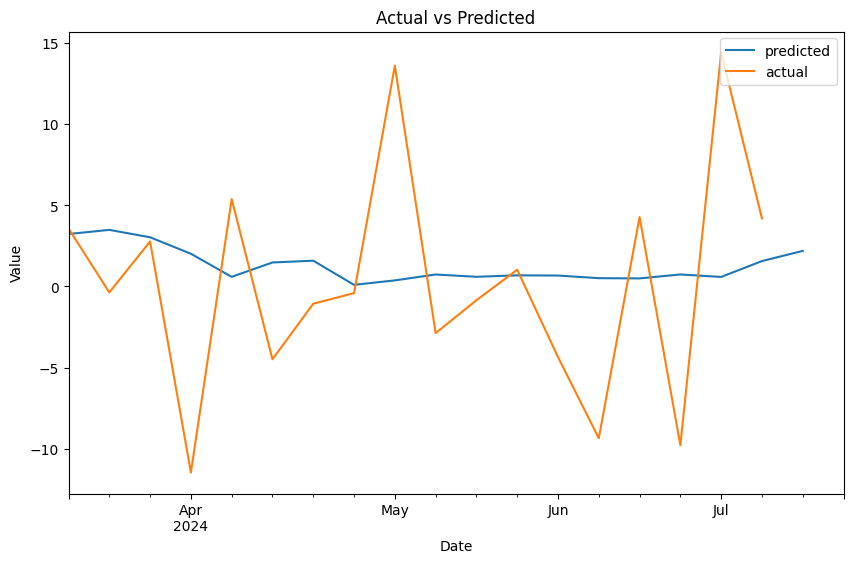

In [65]:
plotdf.tail(20).set_index('Date')[['predicted', 'actual']].plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend(loc='upper right')
plt.show()